In [49]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

import datetime

# 한글 폰트 깨짐 방지
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
train = pd.read_csv("../../Data/Jeju/201901-202003.csv")
submission = pd.read_csv("../../Data/Jeju/submission.csv")

In [5]:
submission

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,0
1,1,202004,강원,골프장 운영업,0
2,2,202004,강원,과실 및 채소 소매업,0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0
...,...,...,...,...,...
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,0
1390,1390,202007,충북,한식 음식점업,0
1391,1391,202007,충북,호텔업,0
1392,1392,202007,충북,화장품 및 방향제 소매업,0


In [6]:
print("In total: ", train.shape)
train.head(5)

In total:  (24697792, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [29]:
# 서울

seoul = train[train["CARD_SIDO_NM"]=="서울"].copy()

In [30]:
# Age

temp = []
for age in seoul.AGE:
    temp.append(int(age.split("s")[0]))

seoul.AGE = temp

In [31]:
# male? female?

seoul["male"] = 0
seoul["female"] = 0
seoul.loc[seoul["SEX_CTGO_CD"]==1, "male"] = 1
seoul.loc[seoul["SEX_CTGO_CD"]==2, "female"] = 1

In [32]:
# FLC 12345?

for i in range(1,6):
    name = "FLC_" + str(i)
    seoul[name]=0
    seoul.loc[seoul["FLC"]==i, name] = 1

In [33]:
# REG_YYMM (date)
seoul.REG_YYMM = pd.to_datetime(seoul.REG_YYMM, format='%Y%m')

In [34]:
temp1 = seoul.groupby(["REG_YYMM", "CARD_SIDO_NM", "STD_CLSS_NM"], 
                       as_index=False)[["CSTMR_CNT", "AMT", "male", "female", 
                                       "FLC_1", "FLC_2", "FLC_3", "FLC_4", "FLC_5"]].sum()
temp2 = seoul.groupby(["REG_YYMM", "CARD_SIDO_NM", "STD_CLSS_NM"], 
                       as_index=False)[["AGE"]].mean()

seoul = pd.concat([temp1, temp2.iloc[:, -1]], axis=1)

seoul

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,CSTMR_CNT,AMT,male,female,FLC_1,FLC_2,FLC_3,FLC_4,FLC_5,AGE
0,2019-01-01,서울,건강보조식품 소매업,15258,1987567326,619,908,121,322,193,371,520,47.125082
1,2019-01-01,서울,골프장 운영업,646,91167430,51,15,0,3,14,30,19,49.848485
2,2019-01-01,서울,과실 및 채소 소매업,195138,7781224692,2820,3365,482,1190,1121,1473,1919,46.515764
3,2019-01-01,서울,관광 민예품 및 선물용품 소매업,9102,201789366,476,952,357,372,306,221,172,37.037815
4,2019-01-01,서울,그외 기타 스포츠시설 운영업,1628,61005100,92,82,40,54,42,35,3,35.114943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2020-03-01,서울,택시 운송업,3335840,78532125499,6562,5956,3150,3068,2126,2193,1981,37.047452
581,2020-03-01,서울,피자 햄버거 샌드위치 및 유사 음식점업,1187691,18715095314,12663,10660,7068,6853,3617,3852,1933,34.487416
582,2020-03-01,서울,한식 음식점업,3208246,147494192925,19996,14588,8860,8880,4802,6733,5309,37.661346
583,2020-03-01,서울,호텔업,30691,3287206791,1360,1054,705,768,369,352,220,34.403480


In [35]:
seoul.index = seoul.REG_YYMM
seoul = seoul.drop("REG_YYMM", axis=1)

# date extraction
seoul['Year'] = seoul.index.year
seoul['Month'] = seoul.index.month
seoul['quarter'] = seoul.index.quarter

# adding new variable
seoul['SalePerCustomer'] = seoul['AMT']/seoul['CSTMR_CNT']
seoul['SalePerCustomer'].describe()

count    5.850000e+02
mean     8.669185e+04
std      1.180659e+05
min      1.139455e+04
25%      2.514842e+04
50%      4.954147e+04
75%      1.031841e+05
max      1.015037e+06
Name: SalePerCustomer, dtype: float64

In [44]:
seoul.head()

,CARD_SIDO_NM,STD_CLSS_NM,CSTMR_CNT,AMT,male,female,FLC_1,FLC_2,FLC_3,FLC_4,FLC_5,AGE,Year,Month,quarter,SalePerCustomer
REG_YYMM,,,,,,,,,,,,,,,,
2019-01-01,서울,건강보조식품 소매업,15258,1987567326,619,908,121,322,193,371,520,47.125082,2019,1,1,130263.948486
2019-01-01,서울,골프장 운영업,646,91167430,51,15,0,3,14,30,19,49.848485,2019,1,1,141126.052632
2019-01-01,서울,과실 및 채소 소매업,195138,7781224692,2820,3365,482,1190,1121,1473,1919,46.515764,2019,1,1,39875.496787
2019-01-01,서울,관광 민예품 및 선물용품 소매업,9102,201789366,476,952,357,372,306,221,172,37.037815,2019,1,1,22169.783125
2019-01-01,서울,그외 기타 스포츠시설 운영업,1628,61005100,92,82,40,54,42,35,3,35.114943,2019,1,1,37472.420147


### ECDF: empirical cumulative distribution function

Text(0.5, 0, 'Sale per Customer')

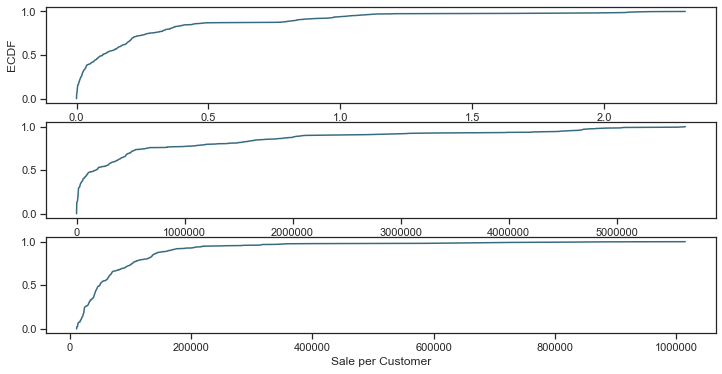

In [45]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(seoul['AMT'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF')

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(seoul['CSTMR_CNT'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers')

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(seoul['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer')

In [46]:
seoul.groupby('STD_CLSS_NM')['AMT'].describe()

,count,mean,std,min,25%,50%,75%,max
STD_CLSS_NM,,,,,,,,
건강보조식품 소매업,15.0,1.380758e+09,2.652138e+08,1.047849e+09,1.185857e+09,1.304819e+09,1.587192e+09,1.987567e+09
골프장 운영업,15.0,3.227929e+08,1.266753e+08,9.116743e+07,2.168252e+08,3.362478e+08,4.211857e+08,5.039887e+08
과실 및 채소 소매업,15.0,7.355404e+09,9.810503e+08,6.185097e+09,6.750283e+09,7.026375e+09,7.719904e+09,9.995268e+09
관광 민예품 및 선물용품 소매업,15.0,2.231199e+08,1.307105e+08,5.358614e+07,1.777634e+08,1.926940e+08,2.125191e+08,5.721488e+08
그외 기타 스포츠시설 운영업,15.0,4.040453e+07,1.194446e+07,1.588850e+07,3.231605e+07,3.914305e+07,4.680178e+07,6.100510e+07
그외 기타 종합 소매업,15.0,3.839115e+10,3.093587e+09,3.309122e+10,3.644197e+10,3.894861e+10,4.026445e+10,4.396160e+10
기타 대형 종합 소매업,15.0,1.002221e+11,8.326972e+09,7.894600e+10,9.852178e+10,1.023291e+11,1.050266e+11,1.102771e+11
기타 수상오락 서비스업,15.0,6.565403e+06,2.048889e+06,3.383100e+06,5.582525e+06,6.455500e+06,7.288425e+06,1.137920e+07
기타 외국식 음식점업,15.0,1.015681e+10,1.170799e+09,7.348439e+09,9.740730e+09,1.022787e+10,1.102947e+10,1.194336e+10


In [47]:
seoul.groupby('STD_CLSS_NM')['AMT', 'CSTMR_CNT'].sum()

,AMT,CSTMR_CNT
STD_CLSS_NM,,
건강보조식품 소매업,20711373484,210837
골프장 운영업,4841893035,38109
과실 및 채소 소매업,110331062192,3006677
관광 민예품 및 선물용품 소매업,3346798725,133602
그외 기타 스포츠시설 운영업,606067892,14857
그외 기타 종합 소매업,575867310193,5661593
기타 대형 종합 소매업,1503331451777,23831975
기타 수상오락 서비스업,98481050,2844
기타 외국식 음식점업,152352172953,6315157


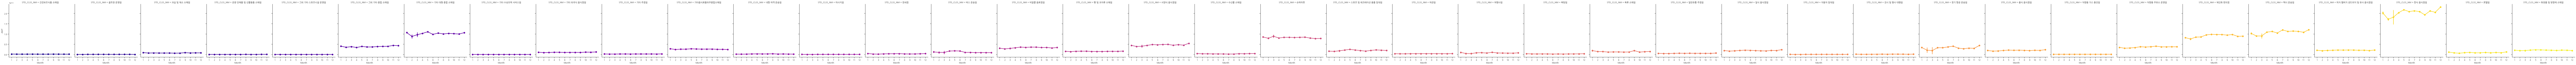

In [50]:
# sales trends
sns.factorplot(data = seoul, x = 'Month', y = "AMT", 
               col = 'STD_CLSS_NM',
               palette = 'plasma',
               hue = 'STD_CLSS_NM',
               color = c) 

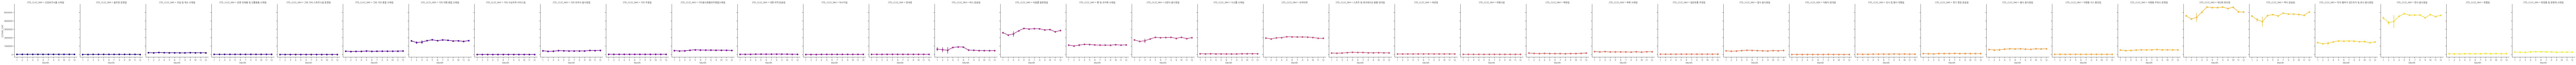

In [51]:
# customer trends
sns.factorplot(data = seoul, x = 'Month', y = "CSTMR_CNT", 
               col = 'STD_CLSS_NM',
               palette = 'plasma',
               hue = 'STD_CLSS_NM',
               color = c) 

In [55]:
seoul.STD_CLSS_NM.unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 수상오락 서비스업',
       '기타 외국식 음식점업', '기타 주점업', '기타음식료품위주종합소매업', '내항 여객 운송업', '마사지업',
       '면세점', '버스 운송업', '비알콜 음료점업', '빵 및 과자류 소매업', '서양식 음식점업', '수산물 소매업',
       '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '여행사업', '욕탕업', '육류 소매업',
       '일반유흥 주점업', '일식 음식점업', '자동차 임대업', '전시 및 행사 대행업', '정기 항공 운송업',
       '중식 음식점업', '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '택시 운송업',
       '피자 햄버거 샌드위치 및 유사 음식점업', '한식 음식점업', '호텔업', '화장품 및 방향제 소매업'],
      dtype=object)

### Seasonality
- 한식 음식점업
- 체인화 편의점
- 기타 대형 종합 소매업
- 택시 운송업

만 예시로 사용

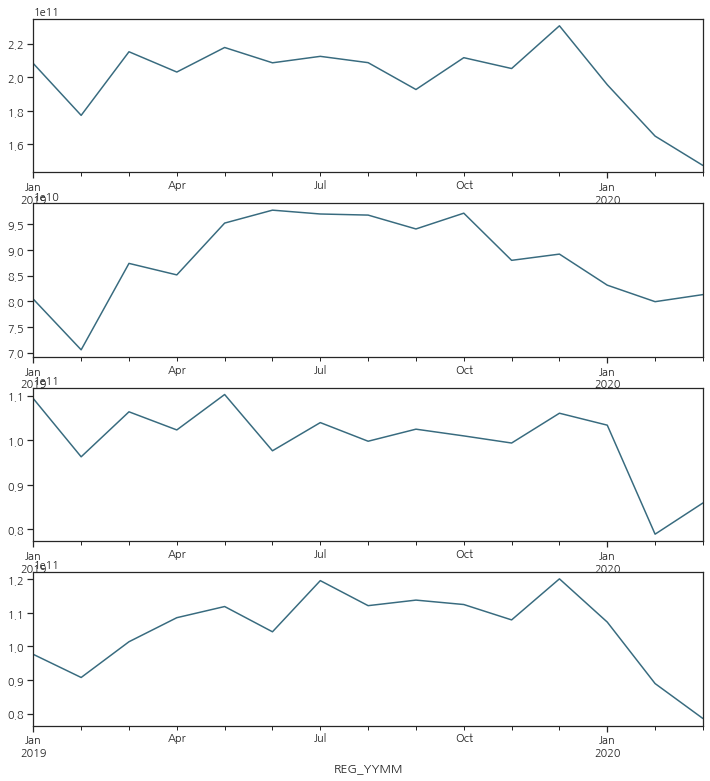

In [57]:
amount_1 = seoul[seoul["STD_CLSS_NM"]=="한식 음식점업"]['AMT']
amount_2 = seoul[seoul["STD_CLSS_NM"]=="체인화 편의점"]['AMT']
amount_3 = seoul[seoul["STD_CLSS_NM"]=="기타 대형 종합 소매업"]['AMT']
amount_4 = seoul[seoul["STD_CLSS_NM"]=="택시 운송업"]['AMT']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
amount_1.plot(color = c, ax = ax1)
amount_2.plot(color = c, ax = ax2)
amount_3.plot(color = c, ax = ax3)
amount_4.plot(color = c, ax = ax4)

### Autocorrelaion
- Autocorrelation Function (ACF)

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

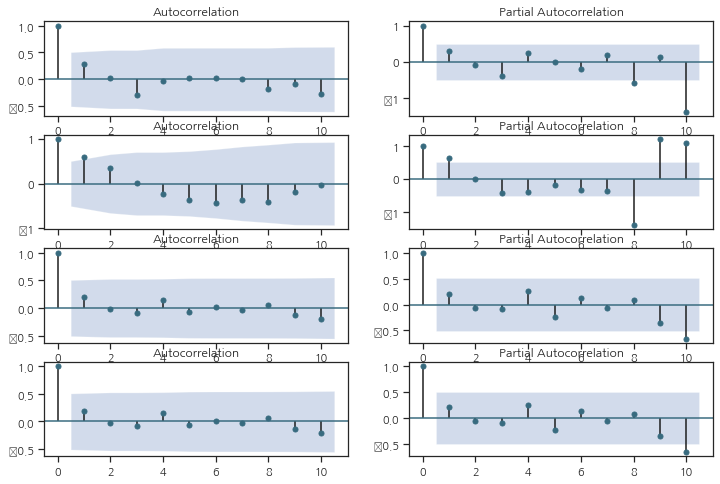

In [67]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(amount_1, lags = 10, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(amount_1, lags = 10, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(amount_2, lags = 10, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(amount_2, lags = 10, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(amount_3, lags = 10, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(amount_3, lags = 10, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(amount_3, lags = 10, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(amount_3, lags = 10, ax = plt.gca(), color = c)

plt.show()